In [19]:
# Kiara Dorion -- ECON 621 -- Robizon -- FINAL PROJECT: Predicting Variables Impacting Futuring Housing Insecurity in the Bay Area

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [310]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/Users/kdorion/Documents/MSAE/2025/Spring 2025/ECON621/FINAL PROJECT/Eviction_Notices_20250305.csv')

# Display remaining columns
print(df.columns)
print(df.head())

Index(['Eviction ID', 'Address', 'City', 'State',
       'Eviction Notice Source Zipcode', 'File Date', 'Non Payment', 'Breach',
       'Nuisance', 'Illegal Use', 'Failure to Sign Renewal', 'Access Denial',
       'Unapproved Subtenant', 'Owner Move In', 'Demolition',
       'Capital Improvement', 'Substantial Rehab', 'Ellis Act WithDrawal',
       'Condo Conversion', 'Roommate Same Unit', 'Other Cause',
       'Late Payments', 'Lead Remediation', 'Development',
       'Good Samaritan Ends', 'Constraints Date', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Location', 'Shape',
       'data_as_of', 'data_loaded_at', 'SF Find Neighborhoods',
       'Current Police Districts', 'Current Supervisor Districts',
       'Analysis Neighborhoods', 'DELETE - Neighborhoods',
       'DELETE - Police Districts', 'DELETE - Supervisor Districts',
       'DELETE - Fire Prevention Districts', 'DELETE - Zip Codes',
       'CBD, BID and GBD Boundaries as of 2017',
       'Central Ma

/var/folders/6j/pmgy91ns295gxlfrv0dz53bmt6tjzs/T/ipykernel_76474/259667033.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/kdorion/Documents/MSAE/2025/Spring 2025/ECON621/FINAL PROJECT/Eviction_Notices_20250305.csv')


In [312]:
# Drop unnecessary columns not relevant to evictions, neighborhoods and dates
columns_to_drop = [
    'Address', 'City', 'State', 'Shape', 'data_as_of', 'data_loaded_at',
    'DELETE - Neighborhoods', 'DELETE - Police Districts', 'DELETE - Supervisor Districts',
    'DELETE - Fire Prevention Districts', 'DELETE - Zip Codes', 'CBD, BID and GBD Boundaries as of 2017', 
    'Central Market/Tenderloin Boundary', 'Central Market/Tenderloin Boundary Polygon - Updated',
    'Fix It Zones as of 2018-02-07'
]
df.drop(columns=columns_to_drop, errors='ignore', inplace=True)

print(df.columns)
print(df.head())

Index(['Eviction ID', 'Eviction Notice Source Zipcode', 'File Date',
       'Non Payment', 'Breach', 'Nuisance', 'Illegal Use',
       'Failure to Sign Renewal', 'Access Denial', 'Unapproved Subtenant',
       'Owner Move In', 'Demolition', 'Capital Improvement',
       'Substantial Rehab', 'Ellis Act WithDrawal', 'Condo Conversion',
       'Roommate Same Unit', 'Other Cause', 'Late Payments',
       'Lead Remediation', 'Development', 'Good Samaritan Ends',
       'Constraints Date', 'Supervisor District',
       'Neighborhoods - Analysis Boundaries', 'Location',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
       'Areas of Vulnerability, 2016', 'Neighborhoods'],
      dtype='object')
  Eviction ID Eviction Notice Source Zipcode   File Date  Non Payment  Breach  \
0     M041544                        94121.0  08/30/2004        False   False   
1     M050324                          941.0  02/28/2005        

In [314]:
# Fill missing numeric values with median
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill missing categorical values with mode (most frequent value)
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Verify missing values
print(df.isnull().sum())

Eviction ID                            0
Eviction Notice Source Zipcode         0
File Date                              0
Non Payment                            0
Breach                                 0
Nuisance                               0
Illegal Use                            0
Failure to Sign Renewal                0
Access Denial                          0
Unapproved Subtenant                   0
Owner Move In                          0
Demolition                             0
Capital Improvement                    0
Substantial Rehab                      0
Ellis Act WithDrawal                   0
Condo Conversion                       0
Roommate Same Unit                     0
Other Cause                            0
Late Payments                          0
Lead Remediation                       0
Development                            0
Good Samaritan Ends                    0
Constraints Date                       0
Supervisor District                    0
Neighborhoods - 

In [316]:
# Convert file date to datetime format
df['File Date'] = pd.to_datetime(df['File Date'], errors='coerce')

# Extract year, month, and day
df['Eviction Year'] = df['File Date'].dt.year
df['Eviction Month'] = df['File Date'].dt.month
df['Eviction Day'] = df['File Date'].dt.day

print(df['Eviction Year'])
print(df['Eviction Month'])
print(df['Eviction Day'])

0        2004
1        2005
2        2006
3        2007
4        2007
         ... 
46555    2000
46556    2000
46557    2000
46558    2000
46559    2000
Name: Eviction Year, Length: 46560, dtype: int32
0         8
1         2
2         1
3         5
4        12
         ..
46555    12
46556    12
46557    12
46558    12
46559    11
Name: Eviction Month, Length: 46560, dtype: int32
0        30
1        28
2         9
3        29
4        20
         ..
46555    26
46556     7
46557     8
46558    11
46559    17
Name: Eviction Day, Length: 46560, dtype: int32


In [318]:
# Count total evictions per neighborhood
eviction_counts = df.groupby('Neighborhoods - Analysis Boundaries')['Eviction ID'].count().reset_index()
eviction_counts.rename(columns={'Eviction ID': 'Total Evictions'}, inplace=True)

# Merge back into the main dataset
df = df.merge(eviction_counts, on='Neighborhoods - Analysis Boundaries', how='left')

In [320]:
print(eviction_counts.head(41))

print(df.columns)

   Neighborhoods - Analysis Boundaries  Total Evictions
0                Bayview Hunters Point             1428
1                       Bernal Heights             1320
2                  Castro/Upper Market             2010
3                            Chinatown              559
4                            Excelsior             1402
5       Financial District/South Beach              833
6                            Glen Park              281
7                     Golden Gate Park               10
8                       Haight Ashbury             1433
9                         Hayes Valley             1668
10                      Inner Richmond             1229
11                        Inner Sunset             1307
12                           Japantown               86
13                           Lakeshore             1998
14                        Lincoln Park               21
15                   Lone Mountain/USF              972
16                              Marina          

In [322]:
# Calculate eviction rate per neighborhood
df['Eviction Rate'] = df['Total Evictions'] / df['Total Evictions'].sum()

print(df['Eviction Rate'])

0        0.000056
1        0.000056
2        0.000056
3        0.000056
4        0.000056
           ...   
46555    0.000015
46556    0.000013
46557    0.000015
46558    0.000014
46559    0.000024
Name: Eviction Rate, Length: 46560, dtype: float64


In [324]:
# Define eviction risk categories (low, medium, high)
df['Eviction Risk'] = pd.qcut(df['Total Evictions'], q=3, labels=['Low', 'Medium', 'High'])

print(df['Eviction Risk'])

0          High
1          High
2          High
3          High
4          High
          ...  
46555    Medium
46556       Low
46557    Medium
46558       Low
46559      High
Name: Eviction Risk, Length: 46560, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']


In [360]:
from sklearn.model_selection import train_test_split

# Select predictor variables
features = [
    'Eviction Rate', 'Eviction Year','Eviction Month','File Date',
    'Neighborhoods - Analysis Boundaries',
    'Breach','Substantial Rehab','Lead Remediation', 'Development', 
    'Supervisor District', 'Demolition','Condo Conversion','Late Payments','Other Cause'
]

# Define X (features) and Y (target variable)
X = df[features]
y = df['Eviction Risk']  # Predicting high, medium, or low eviction risk

# Train-test split (50% train, 50% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [362]:
print(X_train, X_test, y_train, y_test)

       Eviction Rate  Eviction Year  Eviction Month  File Date  \
23942       0.000014           2016              12 2016-12-02   
43137       0.000009           2000              10 2000-10-11   
36818       0.000015           2023               8 2023-08-10   
23737       0.000015           2016               9 2016-09-30   
11285       0.000012           2005               4 2005-04-11   
...              ...            ...             ...        ...   
11284       0.000021           1998              12 1998-12-04   
44732       0.000056           2004               5 2004-05-27   
38158       0.000056           2003              11 2003-11-07   
860         0.000006           2009               1 2009-01-26   
15795       0.000015           1997               4 1997-04-02   

      Neighborhoods - Analysis Boundaries  Breach  Substantial Rehab  \
23942                        Inner Sunset   False              False   
43137                  West of Twin Peaks   False              

In [102]:
#for col in X_train.columns:
 #   if X_train[col].dtype == "object":  # If column contains text
  #      print(f"Unique values in {col}: {X_train[col].unique()[:10]}")  # Print first 10 unique values

Unique values in Neighborhoods - Analysis Boundaries: ['Inner Sunset' 'West of Twin Peaks' 'Bayview Hunters Point'
 'Russian Hill' 'Noe Valley' 'Tenderloin' 'Mission'
 'Financial District/South Beach' 'Pacific Heights' 'Outer Richmond']


In [364]:
# Convert datetime column (if exists) to numeric year format
if "File Date" in X_train.columns:
    X_train["Eviction Year"] = X_train["File Date"].dt.year
    X_test["Eviction Year"] = X_test["File Date"].dt.year
    X_train.drop(columns=["File Date"], inplace=True, errors="ignore")
    X_test.drop(columns=["File Date"], inplace=True, errors="ignore")

In [366]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=["object"]).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])  # Convert to numbers
    X_test[col] = le.transform(X_test[col])  # Apply same encoding to test set
    label_encoders[col] = le  # Store encoder for future use

# Verify all columns are numeric now
print(X_train.dtypes)

Eviction Rate                          float64
Eviction Year                            int32
Eviction Month                           int32
Neighborhoods - Analysis Boundaries      int64
Breach                                    bool
Substantial Rehab                         bool
Lead Remediation                          bool
Development                               bool
Supervisor District                    float64
Demolition                                bool
Condo Conversion                          bool
Late Payments                             bool
Other Cause                               bool
dtype: object


In [368]:
print(X_train.isnull().sum())  # Check for missing values
print(X_train.dtypes)  # Should only show int or float

Eviction Rate                          0
Eviction Year                          0
Eviction Month                         0
Neighborhoods - Analysis Boundaries    0
Breach                                 0
Substantial Rehab                      0
Lead Remediation                       0
Development                            0
Supervisor District                    0
Demolition                             0
Condo Conversion                       0
Late Payments                          0
Other Cause                            0
dtype: int64
Eviction Rate                          float64
Eviction Year                            int32
Eviction Month                           int32
Neighborhoods - Analysis Boundaries      int64
Breach                                    bool
Substantial Rehab                         bool
Lead Remediation                          bool
Development                               bool
Supervisor District                    float64
Demolition                     

In [370]:
# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
rf_model.fit(X_train, y_train)

# Make Predictions
y_pred = rf_model.predict(X_test)

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Model Accuracy: 0.9275
              precision    recall  f1-score   support

        High       0.80      1.00      0.89      6834
         Low       1.00      1.00      1.00      8206
      Medium       1.00      0.80      0.89      8240

    accuracy                           0.93     23280
   macro avg       0.93      0.93      0.93     23280
weighted avg       0.94      0.93      0.93     23280



In [372]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Accuracy: {scores.mean():.4f}")

Cross-Validation Scores: [0.93298969 0.92783505 0.92783505 0.97121993 0.92847938]
Mean Accuracy: 0.9377


In [374]:
# Get feature importance scores
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_importances.head(10))  # Show top 10 features

Eviction Rate                          0.413837
Neighborhoods - Analysis Boundaries    0.302382
Supervisor District                    0.175495
Breach                                 0.041292
Development                            0.029049
Eviction Month                         0.015017
Eviction Year                          0.010107
Condo Conversion                       0.007419
Lead Remediation                       0.002731
Demolition                             0.001842
dtype: float64


In [384]:
# Ensure future_data has the same features as X_train
future_data = future_data[X_train.columns.intersection(future_data.columns)]  # Keep only matching features

# Check if all required columns are present
missing_cols = set(X_train.columns) - set(future_data.columns)
if missing_cols:
    print(f"⚠️ Missing columns in future_data: {missing_cols}")

In [386]:
from sklearn.preprocessing import LabelEncoder

# Reuse the label encoder from training (ensure it was saved earlier)
neighborhood_encoder = LabelEncoder()
future_data["Neighborhoods - Analysis Boundaries"] = neighborhood_encoder.fit_transform(future_data["Neighborhoods - Analysis Boundaries"])

In [388]:
# Convert File Date to year if it's still a datetime column
if "File Date" in future_data.columns and future_data["File Date"].dtype == "datetime64[ns]":
    future_data["Eviction Year"] = future_data["File Date"].dt.year
    future_data.drop(columns=["File Date"], inplace=True)

In [392]:
# Ensure all features match before predicting
future_data = future_data[X_train.columns]

# Predict eviction risk for the next year
future_data["Predicted Eviction Risk"] = rf_model.predict(future_data)

# Display top high-risk neighborhoods
print(future_data[["Neighborhoods - Analysis Boundaries", "Predicted Eviction Risk"]].head(85))

    Neighborhoods - Analysis Boundaries Predicted Eviction Risk
0                                    18                    High
1                                    18                    High
2                                    18                    High
3                                    18                    High
4                                    18                    High
..                                  ...                     ...
80                                   18                    High
81                                   13                  Medium
82                                    2                  Medium
83                                   20                    High
84                                   36                     Low

[85 rows x 2 columns]


/var/folders/6j/pmgy91ns295gxlfrv0dz53bmt6tjzs/T/ipykernel_76474/2930613684.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


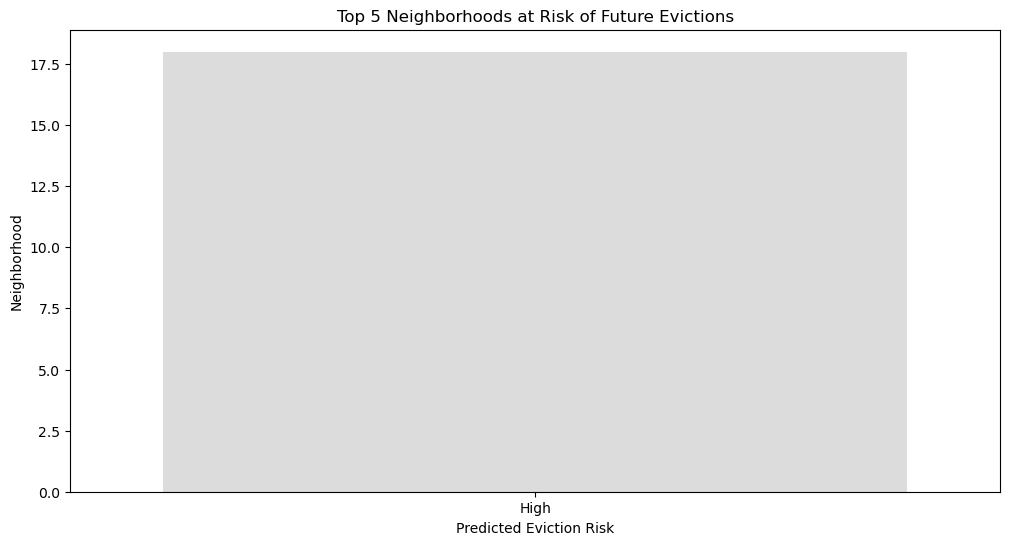

/var/folders/6j/pmgy91ns295gxlfrv0dz53bmt6tjzs/T/ipykernel_76474/2930613684.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=future_data.head(5), x='Predicted Eviction Risk', y='Neighborhoods - Analysis Boundaries', palette='coolwarm')


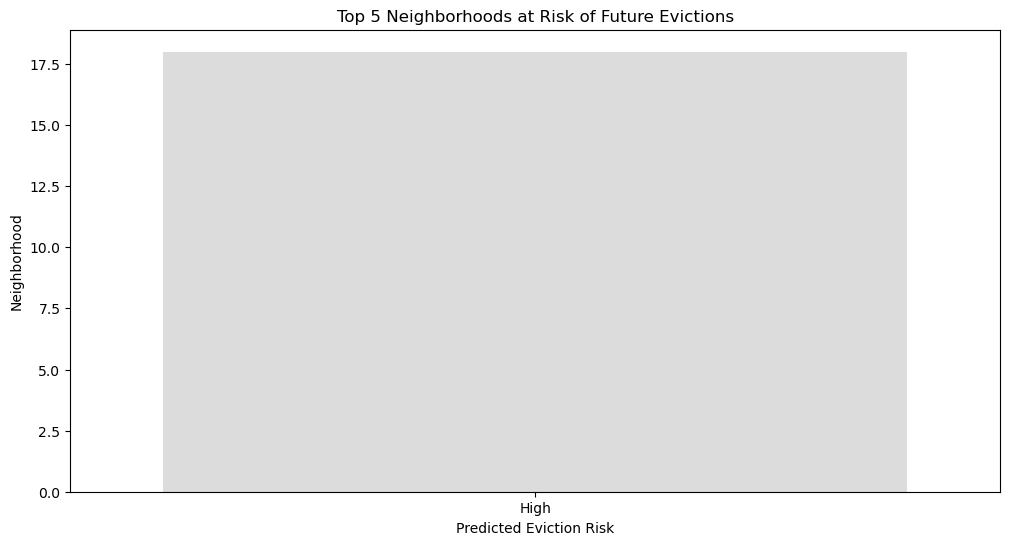

In [396]:
import matplotlib.pyplot as plt
import seaborn as sns

if "Predicted Eviction Risk" in future_data.columns:
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=future_data.head(5), 
        x="Predicted Eviction Risk", 
        y="Neighborhoods - Analysis Boundaries", 
        palette="coolwarm"
    )
    plt.xlabel("Predicted Eviction Risk")
    plt.ylabel("Neighborhood")
    plt.title("Top 5 Neighborhoods at Risk of Future Evictions")
    plt.show()
else:
    print("❌ 'Predicted Eviction Risk' column not found. Check prediction step.")

plt.figure(figsize=(12,6))
sns.barplot(data=future_data.head(5), x='Predicted Eviction Risk', y='Neighborhoods - Analysis Boundaries', palette='coolwarm')
plt.xlabel('Predicted Eviction Risk')
plt.ylabel('Neighborhood')
plt.title('Top 5 Neighborhoods at Risk of Future Evictions')
plt.show()

In [398]:
# Convert 'File Date' to datetime and extract relevant time features
df["File Date"] = pd.to_datetime(df["File Date"], errors="coerce")
df["Eviction Year"] = df["File Date"].dt.year
df["Eviction Month"] = df["File Date"].dt.month

# Summary statistics
eviction_summary = df.describe()
eviction_summary

,File Date,Supervisor District,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,"Areas of Vulnerability, 2016",Neighborhoods,Eviction Year,Eviction Month,Eviction Day,Total Evictions,Eviction Rate
count,46560,46560.000000,46560.000000,46560.000000,46560.000000,46560.000000,46560.000000,46560.000000,46560.000000,46560.000000,46560.000000,46560.000000,4.656000e+04
mean,2009-03-29 14:53:52.577319680,5.970296,52.873926,5.998131,6.154381,21.033698,1.411297,52.873926,2008.751117,6.427470,15.420640,2061.190077,2.147766e-05
min,1997-01-02 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1997.000000,1.000000,1.000000,8.000000,8.336024e-08
25%,2001-05-18 00:00:00,3.000000,25.000000,3.000000,3.000000,11.000000,1.000000,25.000000,2001.000000,4.000000,8.000000,1229.000000,1.280622e-05
50%,2008-11-14 00:00:00,6.000000,47.000000,6.000000,6.000000,20.000000,1.000000,47.000000,2008.000000,6.000000,15.000000,1437.000000,1.497358e-05
75%,2016-01-29 00:00:00,9.000000,84.000000,9.000000,9.000000,32.000000,2.000000,84.000000,2016.000000,9.000000,23.000000,2299.000000,2.395565e-05
max,2025-02-28 00:00:00,11.000000,117.000000,10.000000,11.000000,41.000000,2.000000,117.000000,2025.000000,12.000000,31.000000,5413.000000,5.640362e-05
std,NaN,3.006004,32.955496,2.828597,3.223493,11.625421,0.492074,32.955496,8.135628,3.347642,8.568019,1414.175098,1.473575e-05


In [402]:
eviction_by_neighborhood = df.groupby("Neighborhoods - Analysis Boundaries")["Eviction Rate"].mean().reset_index()
eviction_by_neighborhood.sort_values(by="Eviction Rate", ascending=False, inplace=True)
eviction_by_neighborhood.head(10)  # Top 10 neighborhoods

,Neighborhoods - Analysis Boundaries,Eviction Rate
18,Mission,0.000056
35,Tenderloin,0.000034
34,Sunset/Parkside,0.000030
25,Outer Richmond,0.000024
2,Castro/Upper Market,0.000021
13,Lakeshore,0.000021
33,South of Market,0.000019
20,Nob Hill,0.000018
9,Hayes Valley,0.000017
16,Marina,0.000015


In [404]:
eviction_by_year = df.groupby("Eviction Year")["Eviction Rate"].mean().reset_index()
eviction_by_year

,Eviction Year,Eviction Rate
0,1997,0.000021
1,1998,0.000021
2,1999,0.000021
3,2000,0.000020
4,2001,0.000021
5,2002,0.000021
6,2003,0.000022
7,2004,0.000023
8,2005,0.000024
9,2006,0.000022


/var/folders/6j/pmgy91ns295gxlfrv0dz53bmt6tjzs/T/ipykernel_76474/3064813795.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=eviction_by_neighborhood.head(10),


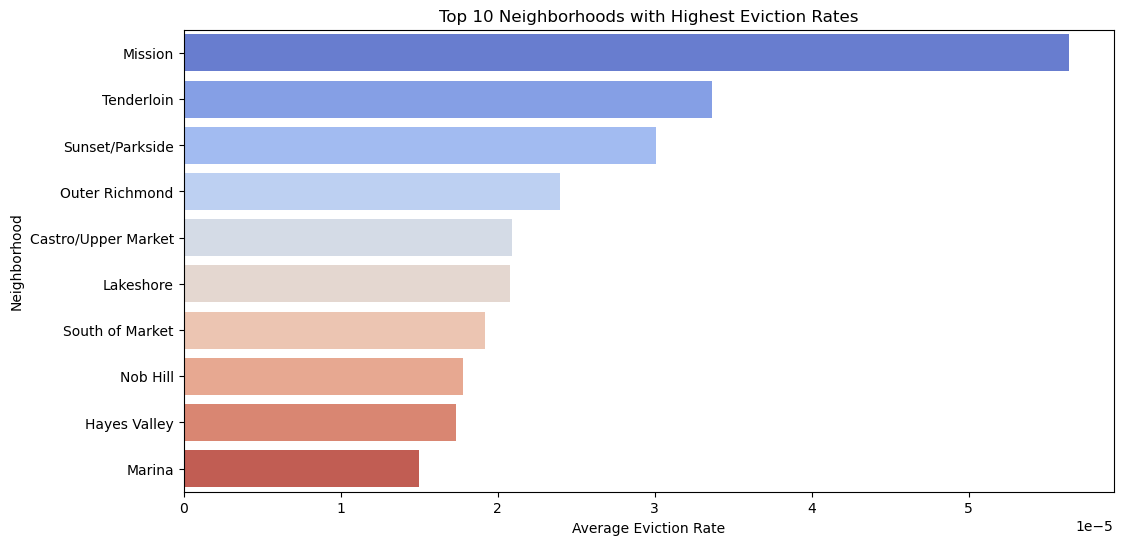

In [406]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=eviction_by_neighborhood.head(10), 
            x="Eviction Rate", 
            y="Neighborhoods - Analysis Boundaries", 
            palette="coolwarm")
plt.title("Top 10 Neighborhoods with Highest Eviction Rates")
plt.xlabel("Average Eviction Rate")
plt.ylabel("Neighborhood")
plt.show()

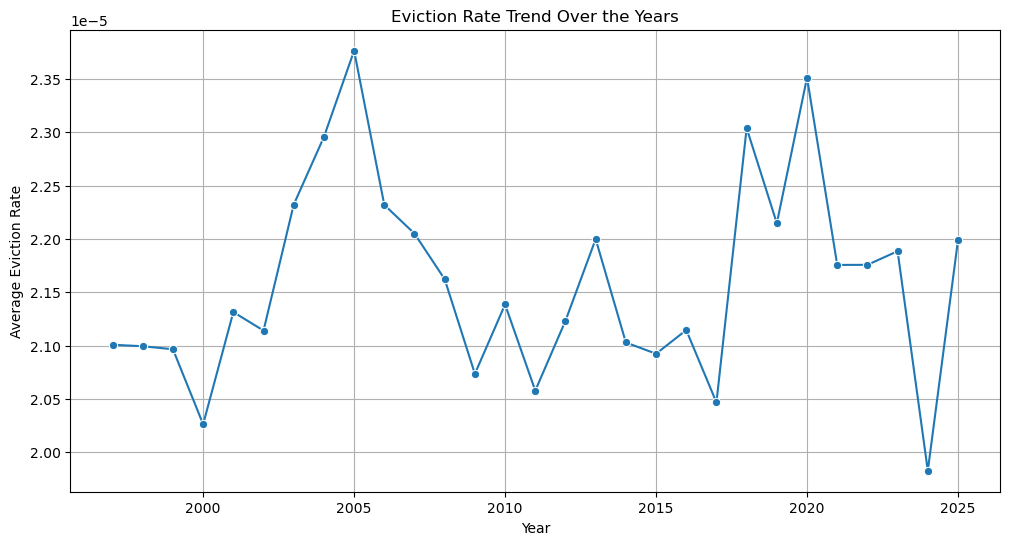

In [408]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=eviction_by_year, x="Eviction Year", y="Eviction Rate", marker="o")
plt.title("Eviction Rate Trend Over the Years")
plt.xlabel("Year")
plt.ylabel("Average Eviction Rate")
plt.grid()
plt.show()

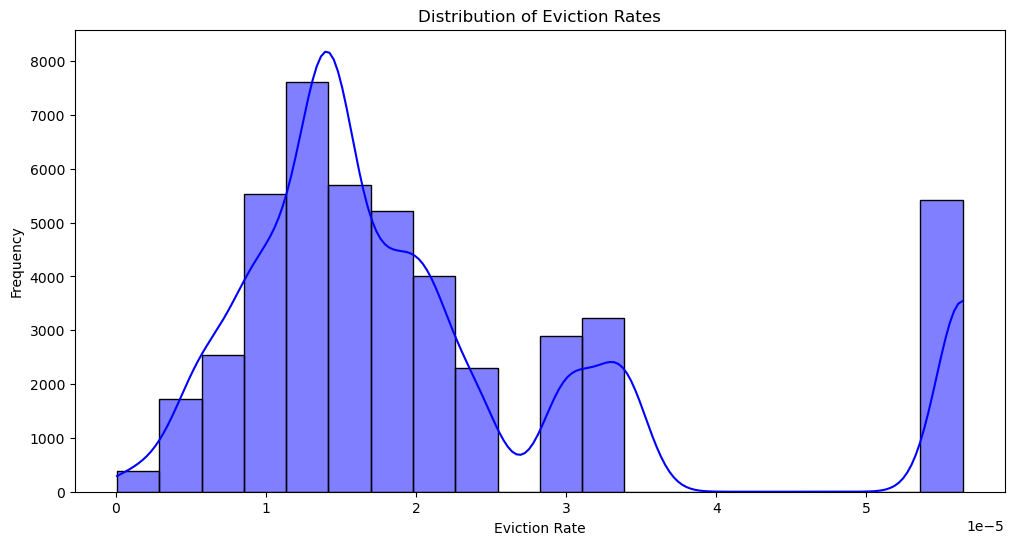

In [410]:
plt.figure(figsize=(12, 6))
sns.histplot(df["Eviction Rate"], bins=20, kde=True, color="blue")
plt.title("Distribution of Eviction Rates")
plt.xlabel("Eviction Rate")
plt.ylabel("Frequency")
plt.show()

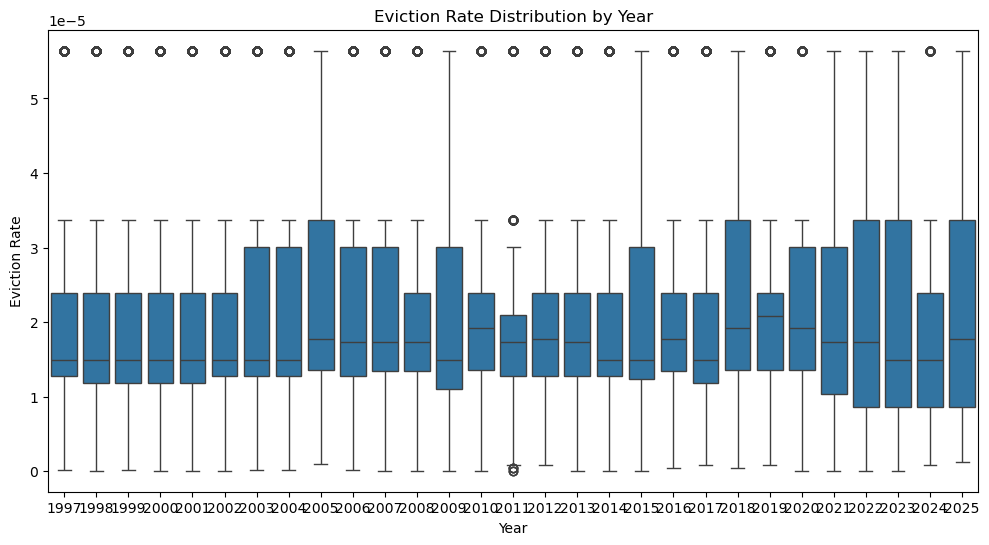

In [412]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="Eviction Year", y="Eviction Rate")
plt.title("Eviction Rate Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Eviction Rate")
plt.show()

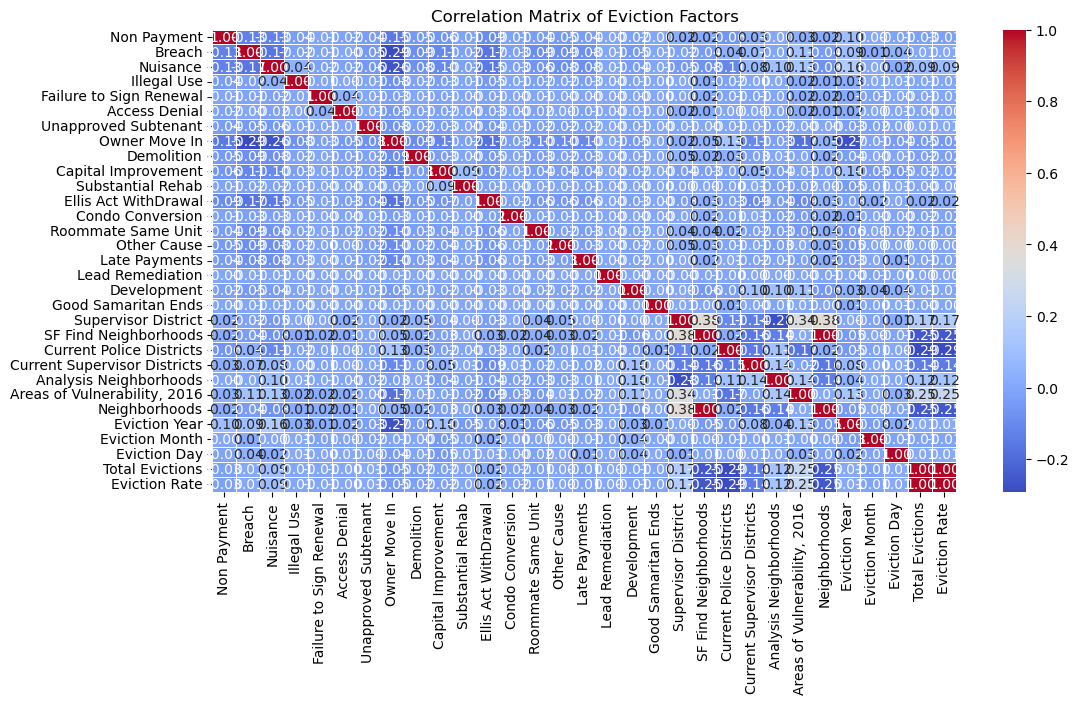

In [414]:
plt.figure(figsize=(12, 6))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Eviction Factors")
plt.show()

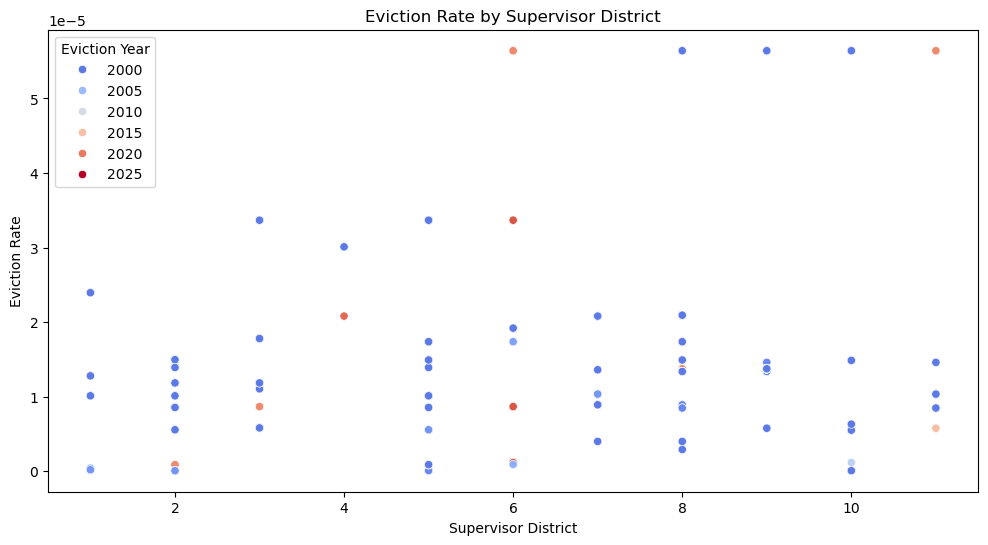

In [416]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="Supervisor District", y="Eviction Rate", hue="Eviction Year", palette="coolwarm")
plt.title("Eviction Rate by Supervisor District")
plt.xlabel("Supervisor District")
plt.ylabel("Eviction Rate")
plt.show()

/var/folders/6j/pmgy91ns295gxlfrv0dz53bmt6tjzs/T/ipykernel_76474/967015920.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Eviction Month", palette="viridis")


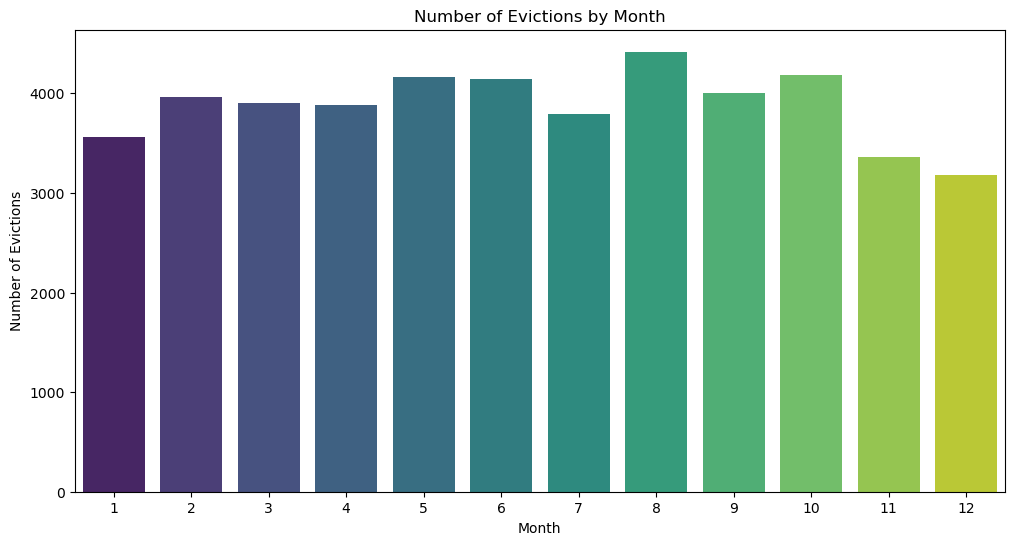

In [418]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Eviction Month", palette="viridis")
plt.title("Number of Evictions by Month")
plt.xlabel("Month")
plt.ylabel("Number of Evictions")
plt.show()

/var/folders/6j/pmgy91ns295gxlfrv0dz53bmt6tjzs/T/ipykernel_76474/1392262488.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=factor_sums.index, y=factor_sums.values, palette="muted")


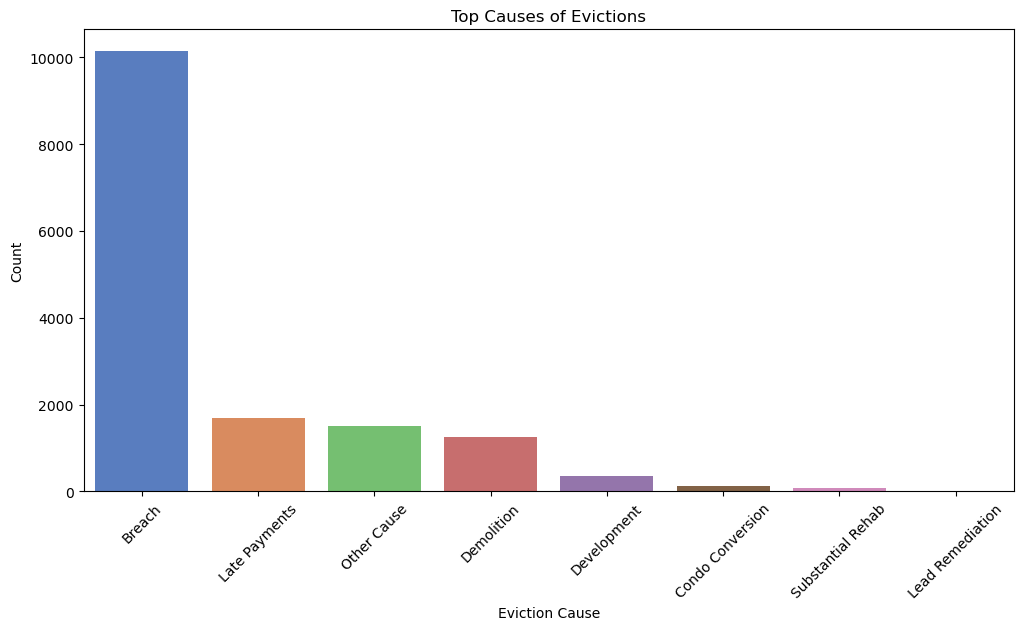

In [420]:
top_factors = ["Breach", "Substantial Rehab", "Lead Remediation", "Development", "Demolition", "Condo Conversion", "Late Payments", "Other Cause"]
factor_sums = df[top_factors].sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=factor_sums.index, y=factor_sums.values, palette="muted")
plt.title("Top Causes of Evictions")
plt.xlabel("Eviction Cause")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()